# Random Reattachment of Fragment Species from Automatic Fragment Modeling (AFM) Simulation Results
AFM allows users to construct mechanisms for large molecules with RMG by breaking them up into two or more fragments. Running simulations with a fragment mechanism is much the same as any other mechanism. However, the species profiles obtained are for individual fragments that may be attached in many combinations. In this notebook, we give an example of random reattachment of fragments produced from polymer pyrolysis, which allows the user to obtain important observables such as molecular weight distribution or the approximate concentration of specific species composed of multiple fragments.

In [1]:
from rmgpy.molecule.fragment import Fragment
from rmgpy.tools.canteramodel import Cantera
from rmgpy.chemkin import load_chemkin_file
from rmgpy.molecule import fragment_utils as frag
import os
import numpy as np
import matplotlib.pyplot as plt

## 1. Set up the simulation...
- load the mechanism


In [2]:
working_dir = os.getcwd()
chemkin_path = os.path.join(working_dir, 'data/chem_annotated.inp')
species_dict_path = os.path.join(working_dir, 'data/species_dictionary.txt')
results_path = os.path.join(working_dir, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)
species_list, reaction_list = load_chemkin_file(
    chemkin_path, species_dict_path)
species_dict = {}
for i, spe in enumerate(species_list):
    species_dict[spe.to_chemkin()] = spe

- specify starting species and conditions


In [3]:
RC10L = species_dict['RC10L(1)']
LC10 = species_dict['LC10(3)']
RC10 = species_dict['RC10(2)']
reactorTypeList = ['IdealGasConstPressureTemperatureReactor']
molFracList = [{RC10: 1,
                RC10L: 160,
                LC10: 1}]
Tlist = ([725.0], 'K')
Plist = ([1.0], 'bar')
# Vlist = ([1], 'm3')
reactionTimeList = ([1], 'h')

- run the simulation

In [4]:
job = Cantera(species_list=species_list,
              reaction_list=reaction_list, output_directory='temp_detailed')
job.load_model()
job.generate_conditions(reactor_type_list=reactorTypeList, reaction_time_list=reactionTimeList,
                        mol_frac_list=molFracList, Tlist=Tlist, Plist=Plist)
all_data = job.simulate()

- get the simulation results

In [5]:
time, dataList, _, _ = all_data[0]
T_data = np.array(dataList[0].data)
P_data = np.array(dataList[1].data)
V_data = np.array(dataList[2].data)
total_moles = P_data/8.314/T_data
total_moles_t0 = total_moles[0]
total_moles_tf = total_moles[-1]
T = Tlist[0][0]
t = reactionTimeList[0][0]

## 2. Random Reattachment Procedure
- make a list of tuples of each fragment species and its final concentration

In [6]:
moles_dict = {}  # key: Chemkin name of fragments, value: moles of fragsments at t_final
for i, mf in enumerate(dataList[6:]):
    spe = species_dict[mf.label].smiles
    moles_dict[spe] = max(mf.data[-1]*total_moles_tf, 0)
frag_list = list(moles_dict.items())

- The following steps describe the role of each function in the `FragList` class.

    1.  The `FragList` object is instantiated with the list of tuples made in the previous cell.

    2.  The `FragList.sort()` function categorizes the fragments by the number of cutting labels.

    3.  The `FragList.pair_CL4s()` function pairs fragments with 4 cutting labels with fragments with 1 cutting label to give fragments with 3 cutting labels.

    4.  The `FragList.pair_CL3s()` function pairs fragments with 3 cutting labels with fragments with 1 cutting label to give fragments with 2 cutting labels (either RR, RL, or LL fragments).

    5.  The `FragList.update_lists()` function adds any remainig fragments with one cutting label to a list of fragments with R cutting labels or a list of fragments with L cutting labels.

    6.  The `FragList.grind_endcaps()` function divides the fragments with 1 cutting label into smaller concentrations (no larger than the `grindsize` variable) to maximize the number of combinations.

    7.  The `FragList.pair_endcaps()` function pairs fragments with 2 of the same cutting label (e.g., LL and RR fragments) with a fragment with 1 cutting label. Then, each subconcentration of fragments with 1 R cutting label is randomly paired to a subconcentration of fragments with 1 L cutting label. These pairs will be the ends of the molecule.

    8.  The `FragList.grind_middles()` function divides the remaining fragments with 2 cutting labels (only LR fragments) into smaller concentrations (no larger than the `grindsize` variable) to maximize the number of combinations. 

    9.  The `FragList.distribute_middles()` function loops through all LR fragments and randomly assigns them to an endcap pair from step 7.

    10. the `FragList.get_mwd()` function plots the histogram of molecular weights of the reattached molecules generated in the previous steps and saves its data under the property `FragList.histdata`.
    
- Random reattachment will be repeated 3 times with a new random seed each time, which will allow us to examine the repeatability of reattachment.


grinding endcaps to 0.0009
grinding middle pieces to 0.0009
grinding endcaps to 0.0009
grinding middle pieces to 0.0009
grinding endcaps to 0.0009
grinding middle pieces to 0.0009


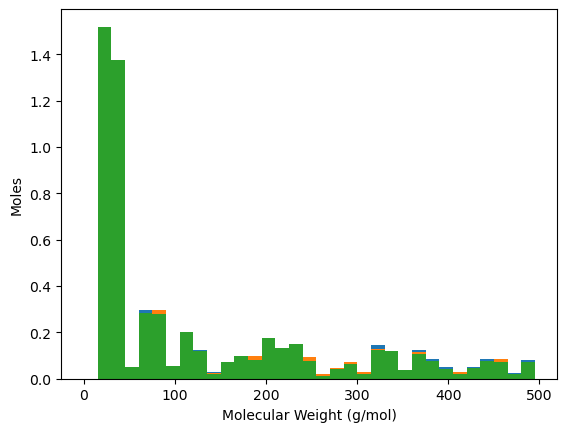

In [11]:
%matplotlib inline
hdl = []
hdl = []
for i in range(3):  
    fl = frag.FragList(frag_list)
    fl.reattach(grindsize=0.0009) # more stable if lower; may need to re-run to do successfully. 
    fl.get_mwd(bins=range(0, 501, 15))
    hdl.append(fl.histdata)  # save histogram data for repeatability analysis



# 3. Analyze Data
- Examine repeatability of random reattachment by overlaying the 10 random reattachment trials from above

- Hint: If the repeatability is not satisfactory, try lowering the grindsize by an order of magnitude

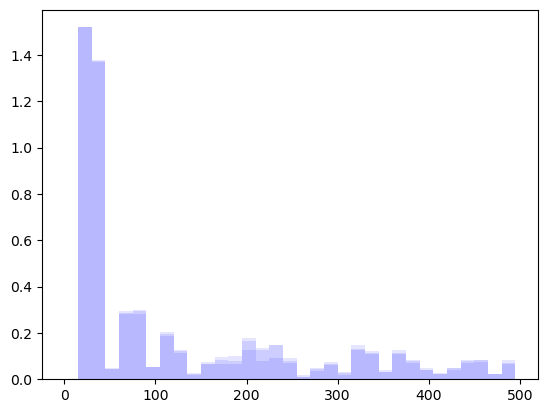

In [12]:
for hd in hdl:
    bins = hd[1]
    counts = hd[0]
    plt.hist(bins[:-1], bins, weights=counts, alpha=0.1, color='blue')

- List the molecules with the highest concentrations

In [ ]:
results_dictionary = {}
for fraglist, amt in fl.grouped:
    fraglist = [Fragment().from_smiles_like_string(x) for x in fraglist]
    if len(fraglist) == 1:
        new = fraglist[0].smiles
    elif len(fraglist) < 6:
        new = frag.merge_frag_list(fraglist)[0].smiles
    else:
        new = 'miscillaneous large molecules'
    if new in results_dictionary.keys():
        results_dictionary[new] += amt
    else:
        results_dictionary[new] = amt
sorted_rd = sorted(results_dictionary.items(), key=lambda x: x[1])[::-1]
total = sum([x[1] for x in sorted_rd])
print('species'.ljust(80), 'mole percent'.rjust(30))
for x, y in sorted_rd:
    print(str(x).ljust(80, '.') +
          str(str(np.round(y/total*100, 2))+'%').rjust(30, '.'))